[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cdrc1103/MasterThesis/blob/master/Experiments/MutiLabel/BERTForPatents.ipynb)

### Setup Notebook

In [1]:
import tensorflow as tf
import os

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.10.58.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.58.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
%%capture
%matplotlib inline
!pip install wandb
!pip install -qq transformers
!pip install datasets

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Data & Parameters



In [4]:
import json
from pathlib import Path
import pandas as pd

RUN_ID = "2.2_A5000MIX"
BASE_DIR = Path(f"gdrive/MyDrive/Colab Notebooks/Thesis")
RUN_DIR = BASE_DIR / "MultiLabel/Runs"

# Load parameters
class Parameter():
  def __init__(self):
    self.__dict__ = {
      "project_name": "thesis_multi-label",
      "train_dataset": "train_A5000MIX.csv",
      "test_dataset": "test_A5000MIX.csv",
      "embedding_dataset": "bert-for-patents",
      "max_tokens": 39000, # vocabulary size
      "embedding_dim": 1024,
      "batch_size": 32,
      "learning_rate": 3e-5,
      "epochs": 2,
      "seed": 1, # random seed for reproducability
      "logging": True, # whether to log to the wandb database (True) or to disk (False)
      "n_classes": 18,
      "in_feature": "abstract", # feature used for training
      "max_token_length": 30, # number of words/subwords, an instance is truncated to
      "out_feature": "label", # feature to predict
      "output_size": 1024, # output size of the language processing layer, i.e. the CNN, GRU etc. layer
      "dropout_rate": 0.1, # for regularization
      "threshold": 0.5,
      "add_special_token": None, # add indicator for patent part as special token, can be: None, abstract, invention, claim, summary, cpc
    }

# Save to disk          
PARAMS = Parameter()
with open(RUN_DIR / f"{RUN_ID}.json", "w") as f:
  json.dump(PARAMS.__dict__, f)

# Read data sets
train_df = pd.read_csv(BASE_DIR / PARAMS.train_dataset, index_col=0)
train_df = train_df.sample(frac=1, random_state=PARAMS.seed)
x_train = train_df[PARAMS.in_feature]
y_train = train_df[train_df.columns.difference([PARAMS.in_feature], sort=False)].to_numpy()
test_df = pd.read_csv(BASE_DIR / PARAMS.test_dataset, index_col=0)
test_df = test_df.sample(frac=1, random_state=PARAMS.seed)
x_test = test_df[PARAMS.in_feature]
y_test = test_df[test_df.columns.difference([PARAMS.in_feature], sort=False)].to_numpy()

# Print stats
print(f"Train data set:{len(train_df)} instances")
print(f"Test data set:{len(test_df)} instances")

Train data set:168245 instances
Test data set:34100 instances


## Configure logging

In [5]:
# Logging
import wandb

# log to wandb
if PARAMS.logging:
    !wandb login
    run = wandb.init(project=PARAMS.project_name)
    run.name = RUN_ID
    log_dir = Path(wandb.run.dir)
    wandb.config.update(PARAMS.__dict__)
# log to disk
else:
    log_dir = RUN_DIR

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: cdrc1103 (use `wandb login --relogin` to force relogin)


## Model

In [6]:
""" Dependencies """
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel, BertTokenizerFast, BertConfig
from datasets import Dataset

""" Configure tokenizer """
config = BertConfig.from_json_file(BASE_DIR/"bert_for_patents_large_config.json")
config.num_labels=PARAMS.n_classes
tokenizer = BertTokenizerFast(BASE_DIR/"bert_for_patents_vocab_39k.txt", config=config)
if PARAMS.add_special_token:
  tokenizer.add_special_tokens({"additional_special_tokens": [f"[{PARAMS.in_feature}]"]})

""" Create TF datasets """

if PARAMS.add_special_token:
  # Add special tokens
  x_train = x_train.apply(lambda x: f"[{PARAMS.in_feature}] {x}")
  x_test = x_test.apply(lambda x: f"[{PARAMS.in_feature}] {x}")

# Aggregate features
x_train = Dataset.from_pandas(pd.DataFrame(x_train))
x_test = Dataset.from_pandas(pd.DataFrame(x_test))

# Tokenize
def tokenize(batch):
    return tokenizer(batch[PARAMS.in_feature], truncation=True, padding=True, max_length=PARAMS.max_token_length)
x_train = x_train.map(tokenize, batched=True, batch_size=PARAMS.batch_size)
x_test = x_test.map(tokenize, batched=True, batch_size=PARAMS.batch_size)

# Transform to tensorflow data set 
x_train.set_format(type='tensorflow', columns=['attention_mask','input_ids'])
x_train = {x: x_train[x].to_tensor(default_value=0) for x in ['input_ids', 'attention_mask']}
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(PARAMS.batch_size)
# Transform validation data set
x_test.set_format(type='tensorflow', columns=['attention_mask','input_ids'])
x_test = {x: x_test[x].to_tensor(default_value=0) for x in ['input_ids', 'attention_mask']}
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(PARAMS.batch_size)

""" Define model architecture """
def build_model():
  input_ids = Input(shape=PARAMS.max_token_length, name='input_ids', dtype='int32')
  attention_mask = Input(shape=PARAMS.max_token_length, name='attention_mask', dtype='int32')
  transformer_model = TFBertModel.from_pretrained(BASE_DIR/"pytorch_model.bin", config=config, from_pt=True)
  embedding = transformer_model.layers[0](input_ids, attention_mask=attention_mask)[1]
  dropout = Dropout(PARAMS.dropout_rate)(embedding)
  output = Dense(PARAMS.n_classes, activation='sigmoid')(dropout)
  return Model(inputs={"input_ids": input_ids, "attention_mask": attention_mask}, outputs=output)

## Training

In [7]:
from tensorflow.keras.callbacks import TensorBoard
from wandb.keras import WandbCallback

""" Transfer to TPU """
with strategy.scope():
  model = build_model()
  optimizer = tf.keras.optimizers.Adam(learning_rate=PARAMS.learning_rate, epsilon=1e-08, clipnorm=1.0)
  loss = BinaryCrossentropy()
  metrics = [
    Precision(name='precision', thresholds=PARAMS.threshold), # Precision is the percentage of predicted positives that were correctly classified
    Recall(name='recall', thresholds=PARAMS.threshold), # Recall is the percentage of actual positives that were correctly classified
  ]
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  # train the model
  history = model.fit(
    x=train_ds,
    epochs=PARAMS.epochs,
    verbose=1,
    validation_data=test_ds
    )

pd.DataFrame(history.history).to_csv(log_dir/"history.csv")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/2


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 18) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 18) dtype=int64>]


5258/5258 [==============================] - ETA: 0s - loss: 0.1402 - precision: 0.7793 - recall: 0.6208

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 18) dtype=int64>]


5258/5258 [==============================] - 1056s 171ms/step - loss: 0.1402 - precision: 0.7793 - recall: 0.6208 - val_loss: 0.1061 - val_precision: 0.7310 - val_recall: 0.6863
Epoch 2/2
5258/5258 [==============================] - 788s 150ms/step - loss: 0.0852 - precision: 0.8610 - recall: 0.7943 - val_loss: 0.1064 - val_precision: 0.7469 - val_recall: 0.7175


In [8]:
from contextlib import redirect_stdout

""" Generate model summary """
print(model.summary())
with open(log_dir/'model_summary.txt', 'w') as file:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: file.write(x + '\n'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 344702976   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 1024)         0           bert[0][1]                   

## Evaluate

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, brier_score_loss, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import math

In [10]:
# Get predictions on test dataset
with strategy.scope():
  predictions = model.predict(
      x=test_ds,
      verbose=1,
      batch_size=PARAMS.batch_size
  ) # Probability distribution over the labels
np.savetxt(log_dir/"predictions.txt", predictions)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 18) dtype=int64>]


1066/1066 [==============================] - 44s 35ms/step


In [11]:
ptopk = predictions.copy()
ptopk[ptopk > PARAMS.threshold] = 1
ptopk[ptopk <= PARAMS.threshold] = 0

metric_funcs = {
    "Precision": Precision(name='precision', thresholds=PARAMS.threshold), # Precision is the percentage of predicted positives that were correctly classified
    "Recall": Recall(name='recall', thresholds=PARAMS.threshold) # Recall is the percentage of actual positives that were correctly classified
}

metric_results ={}
for key, m in metric_funcs.items():
    m.update_state(y_test, ptopk)
    metric_results[key] = m.result().numpy()
if PARAMS.logging:
  wandb.log(metric_results)

In [12]:
# Hamming loss
def hamming_loss(pred_topk, truth):
    equals = pred_topk - truth
    equals = np.sum(1 - np.isin(equals, 0))
    return 1/(truth.shape[0]*truth.shape[1])*equals
if PARAMS.logging:
  wandb.log({"hamming_loss": hamming_loss(ptopk, y_test)})


In [13]:
# Exact match
def exact_match(pred_topk, truth):
    equals = pred_topk - truth
    equals = np.sum(equals, axis=1)
    return 1 - (np.count_nonzero(equals) / truth.shape[0])
if PARAMS.logging:
  wandb.log({"exact_match": exact_match(ptopk, y_test)})

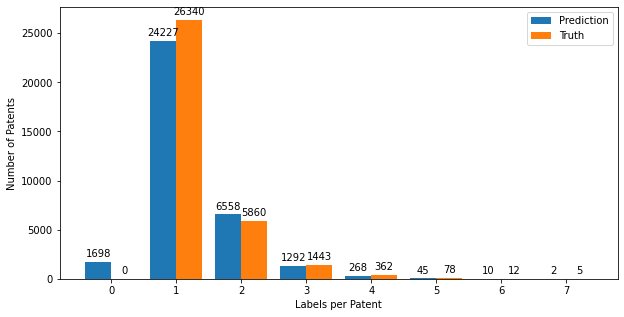

In [14]:
def count_labels(pred_topk, truth):
    # difference between number of predicted and true labels
    pred_sum = np.sum(pred_topk, 1)
    truth_sum = np.sum(truth, 1)
    fig, ax = plt.subplots(figsize=(10,5))
    width = 0.4
    pred_labels, pred_counts = np.unique(pred_sum, return_counts=True)
    pred_labels = pred_labels.astype(int)
    truth_labels, truth_counts = np.unique(truth_sum, return_counts=True)
    all_labels = np.arange(0, max(max(pred_labels), max(truth_labels))+1)
    new_pred_counts = np.zeros(len(all_labels))
    new_pred_counts[pred_labels] = pred_counts
    new_truth_counts = np.zeros(len(all_labels))
    new_truth_counts[truth_labels] = truth_counts 
    bars1 = ax.bar(all_labels - width/2, new_pred_counts, width=width, align='center')
    bars2 = ax.bar(all_labels + width/2, new_truth_counts, width=width, align='center')
    ax.set_xticks(all_labels)
    plt.legend(["Prediction", "Truth"])
    plt.xlabel("Labels per Patent")
    plt.ylabel("Number of Patents")

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(bars1)
    autolabel(bars2)
    plt.savefig(log_dir/"label_counts.png", dpi=150)
count_labels(ptopk, y_test)

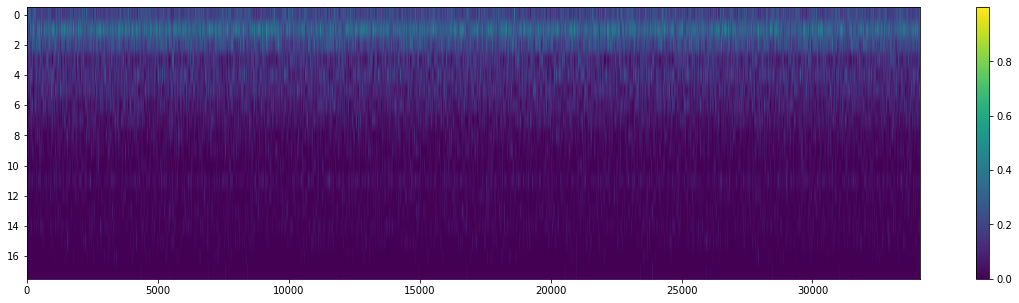

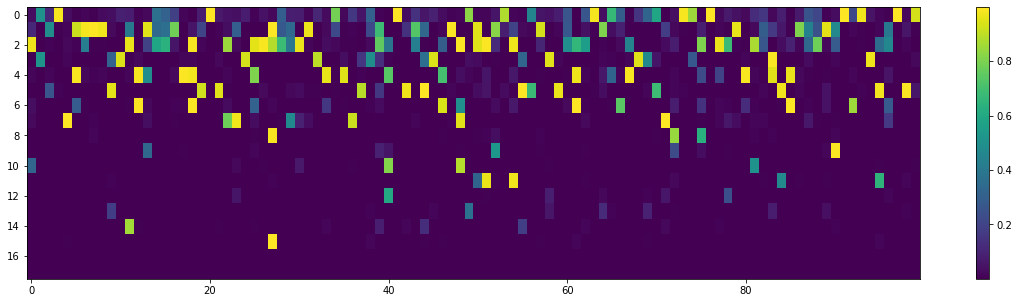

In [15]:
def plot_prediction_probs(pred_raw):
    # full set of predictions
    pic = pred_raw.transpose()
    fig = plt.figure(figsize=(20,5))
    im = plt.imshow(pic, aspect='auto')
    plt.colorbar(im)
    plt.savefig(log_dir/"prediction_probs.png", dpi=150)

    # subset of randomly selected predictions
    ids = np.random.randint(0,len(pred_raw),100)
    pic = pred_raw[ids,:].transpose()
    fig = plt.figure(figsize=(20,5))
    im = plt.imshow(pic, aspect='auto')
    plt.colorbar(im)
    plt.savefig(log_dir/"prediction_probs_100.png", dpi=150)
plot_prediction_probs(predictions)

In [16]:
# Calculate metrics per label
def create_report(true_label, pred_label, n_classes):
  cls_names =[str(cls) for cls in np.arange(0, n_classes)]
  cls_report = classification_report(true_label, pred_label, target_names=cls_names, output_dict=True)
  return pd.DataFrame(cls_report).round(2).transpose()

cls_report = create_report(y_test, ptopk, PARAMS.n_classes)
cls_report.to_csv(log_dir/"cls_report.csv")
if PARAMS.logging:
  wandb.log({"f1-score": cls_report["f1-score"].to_dict()})
cls_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.75,0.53,0.62,6817.0
1,0.79,0.77,0.78,10321.0
2,0.68,0.71,0.69,6934.0
3,0.78,0.91,0.84,3610.0
4,0.81,0.77,0.79,4493.0
5,0.70,0.84,0.77,2836.0
6,0.74,0.70,0.72,2739.0
7,0.71,0.70,0.71,1629.0
8,0.78,0.77,0.77,1024.0
9,0.84,0.65,0.73,945.0


## Save loggings

In [17]:
""" Submit results """
if PARAMS.logging:
    run.join()
    run.finish()

Precision,0.74687
Recall,0.71749
_runtime,2189
_timestamp,1624627454
_step,3
hamming_loss,0.03797
exact_match,0.73032


Precision,▁
Recall,▁
_runtime,▁▁▁█
_timestamp,▁▁▁█
_step,▁▃▆█
hamming_loss,▁
exact_match,▁
